In [1]:
import math,os
import random
from dataclasses import dataclass
from typing import Callable, Tuple, List

In [2]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt


=== Training on f1 ===


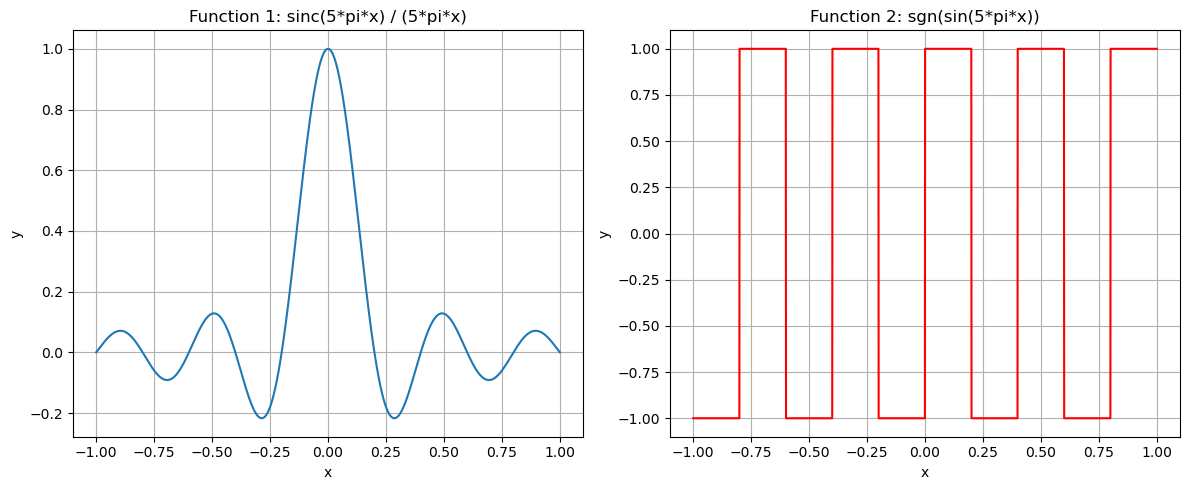

Saved: results/targets_f1_f2_side_by_side.png


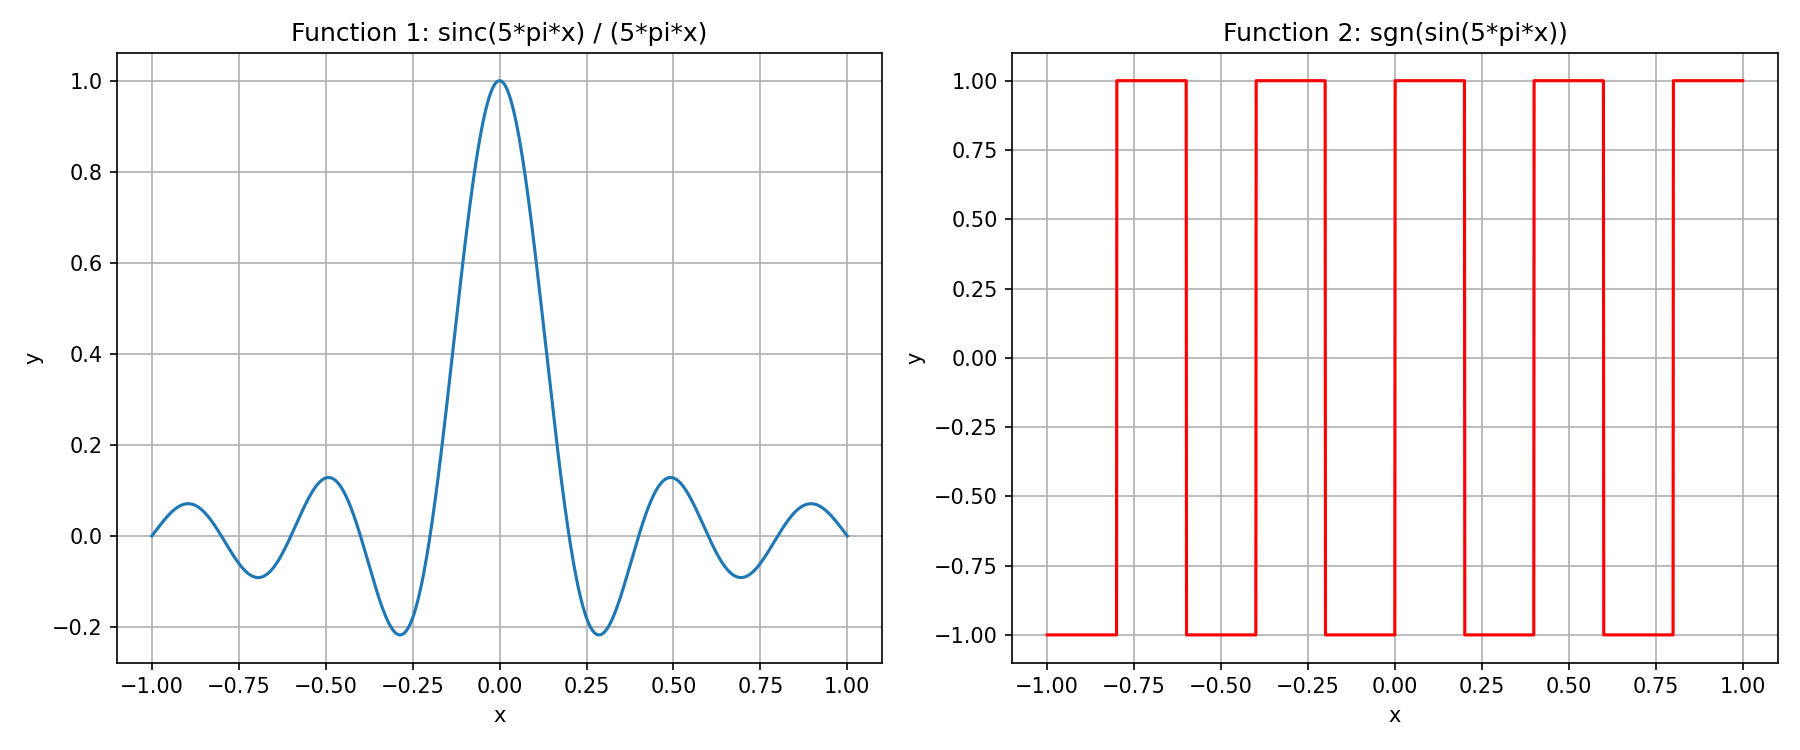

Params -> Model 1 (Shallow): 601, Model 2 (Moderate): 601, Model 3 (Deep): 601
➡️  Training Model 1 (Shallow) on function f1 ...
   epoch   200/20000 | loss 0.02586543 | lr 2.00e-03
   epoch   400/20000 | loss 0.00741045 | lr 2.00e-03
   epoch   600/20000 | loss 0.00538491 | lr 2.00e-03
   epoch   800/20000 | loss 0.00434646 | lr 1.99e-03
   epoch  1000/20000 | loss 0.00335418 | lr 1.99e-03
   epoch  1200/20000 | loss 0.00241053 | lr 1.98e-03
   epoch  1400/20000 | loss 0.00185256 | lr 1.98e-03
   epoch  1600/20000 | loss 0.00173402 | lr 1.97e-03
   epoch  1800/20000 | loss 0.00156184 | lr 1.96e-03
   epoch  2000/20000 | loss 0.00148735 | lr 1.95e-03
   epoch  2200/20000 | loss 0.00142286 | lr 1.94e-03
   epoch  2400/20000 | loss 0.00129281 | lr 1.93e-03
   epoch  2600/20000 | loss 0.00129383 | lr 1.92e-03
   epoch  2800/20000 | loss 0.00118947 | lr 1.90e-03
   epoch  3000/20000 | loss 0.00137809 | lr 1.89e-03
   epoch  3200/20000 | loss 0.00108267 | lr 1.88e-03
   epoch  3400/20000 | 

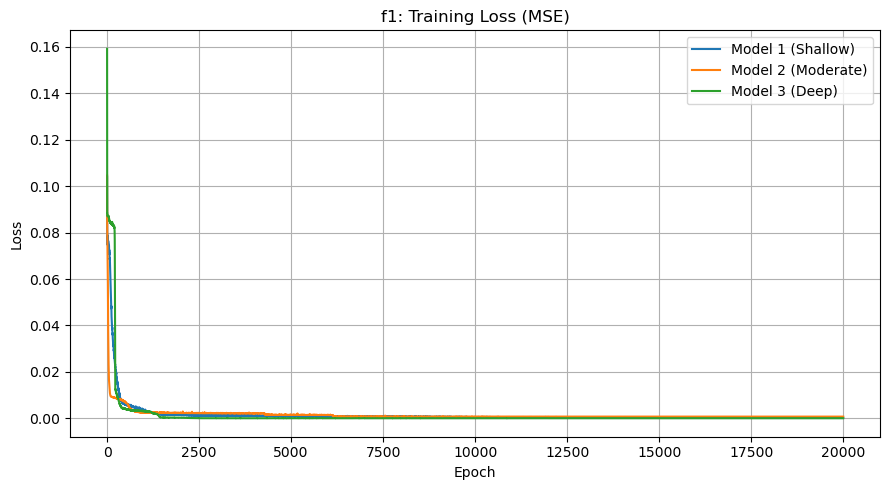

Saved: results/f1_loss.png


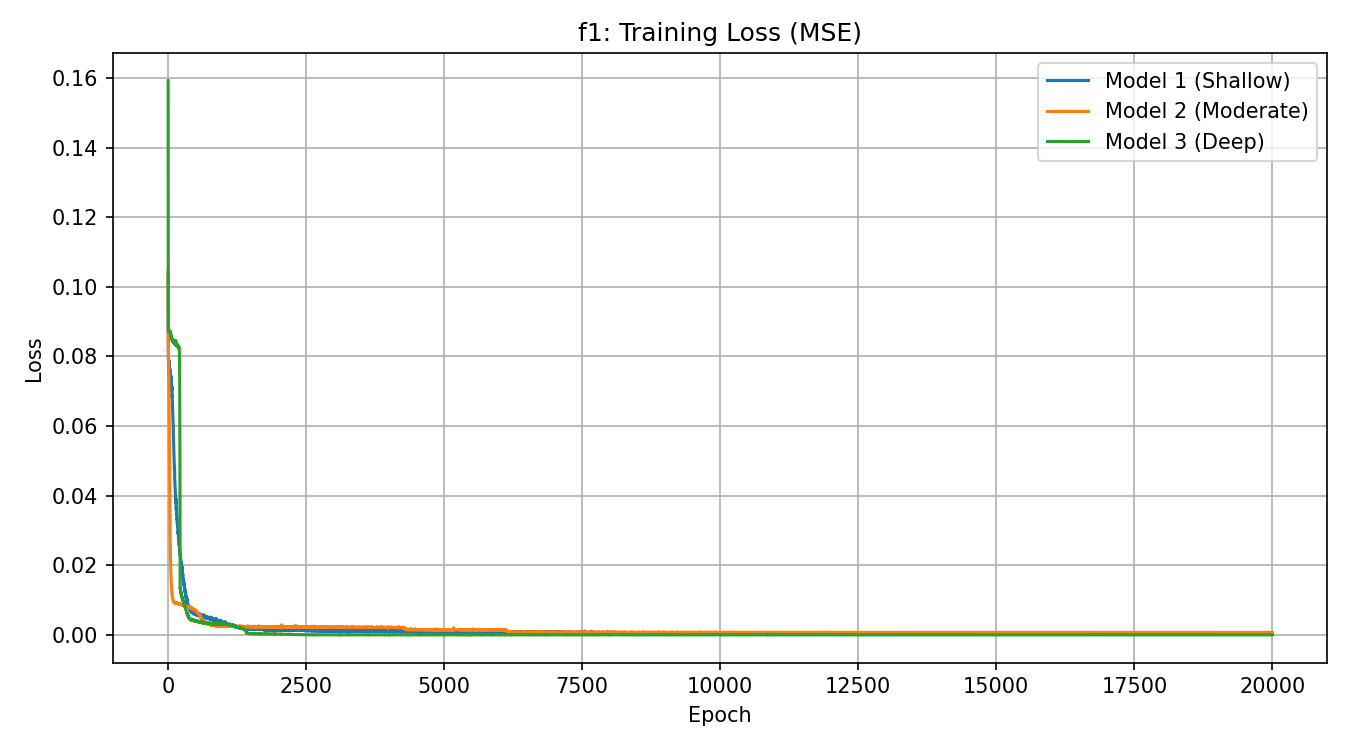

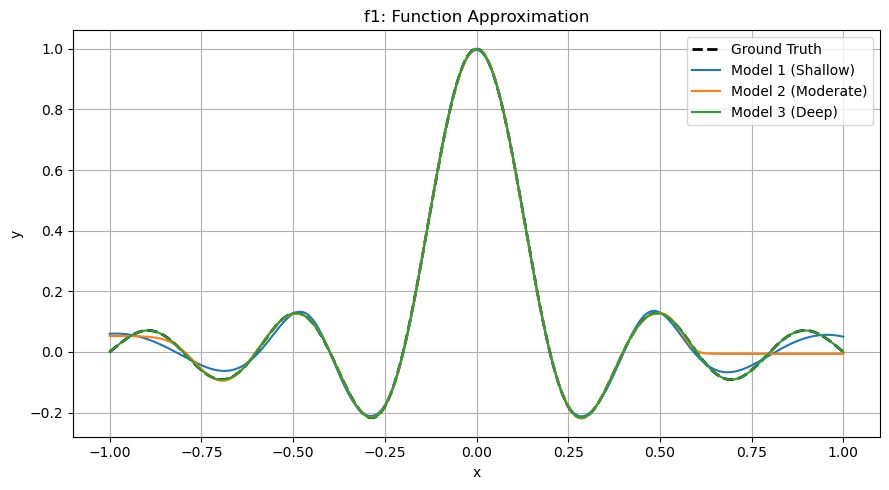

Saved: results/f1_fit.png


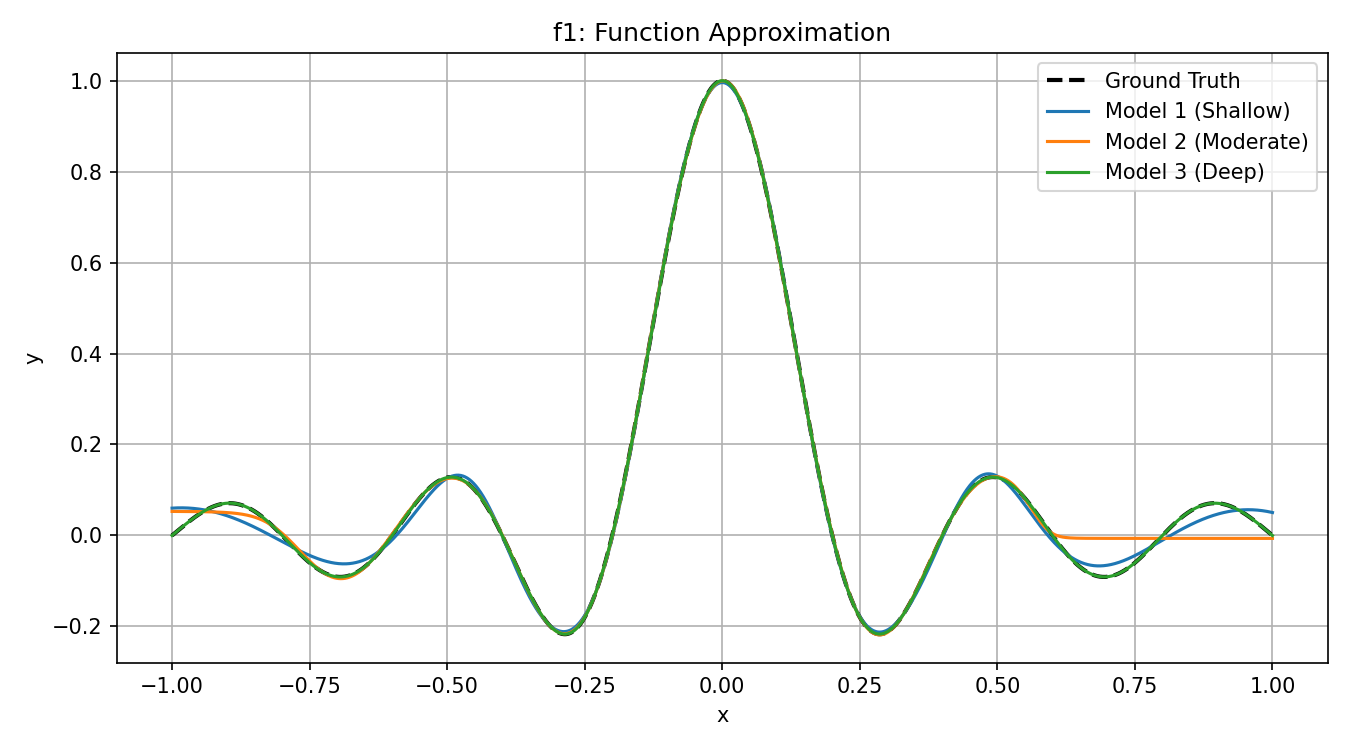


=== Training on f2 ===
Params -> Model 1 (Shallow): 601, Model 2 (Moderate): 601, Model 3 (Deep): 601
➡️  Training Model 1 (Shallow) on function f2 ...
   epoch   200/20000 | loss 0.93067522 | lr 2.00e-03
   epoch   400/20000 | loss 0.92537746 | lr 2.00e-03
   epoch   600/20000 | loss 0.92156211 | lr 2.00e-03
   epoch   800/20000 | loss 0.91175510 | lr 1.99e-03
   epoch  1000/20000 | loss 0.88892449 | lr 1.99e-03
   epoch  1200/20000 | loss 0.87897654 | lr 1.98e-03
   epoch  1400/20000 | loss 0.86433414 | lr 1.98e-03
   epoch  1600/20000 | loss 0.85668617 | lr 1.97e-03
   epoch  1800/20000 | loss 0.83425260 | lr 1.96e-03
   epoch  2000/20000 | loss 0.81107713 | lr 1.95e-03
   epoch  2200/20000 | loss 0.79554640 | lr 1.94e-03
   epoch  2400/20000 | loss 0.77341470 | lr 1.93e-03
   epoch  2600/20000 | loss 0.76227067 | lr 1.92e-03
   epoch  2800/20000 | loss 0.73530410 | lr 1.90e-03
   epoch  3000/20000 | loss 0.71249700 | lr 1.89e-03
   epoch  3200/20000 | loss 0.64488343 | lr 1.88e-03

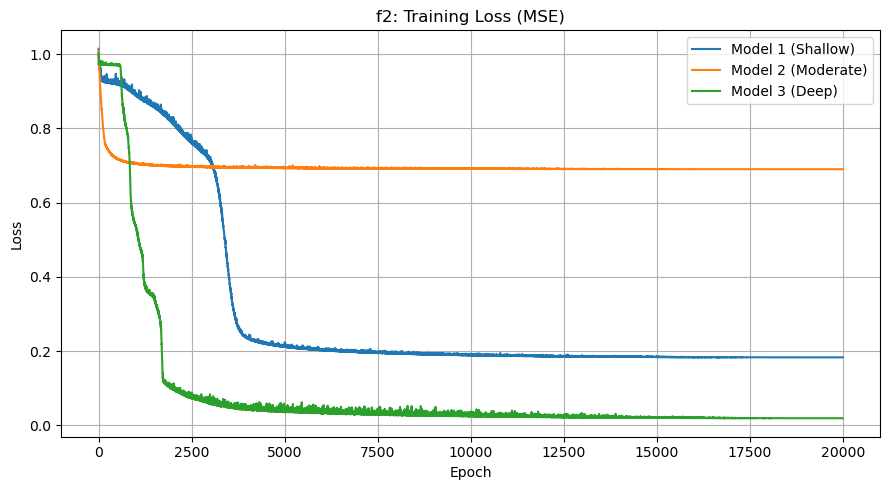

Saved: results/f2_loss.png


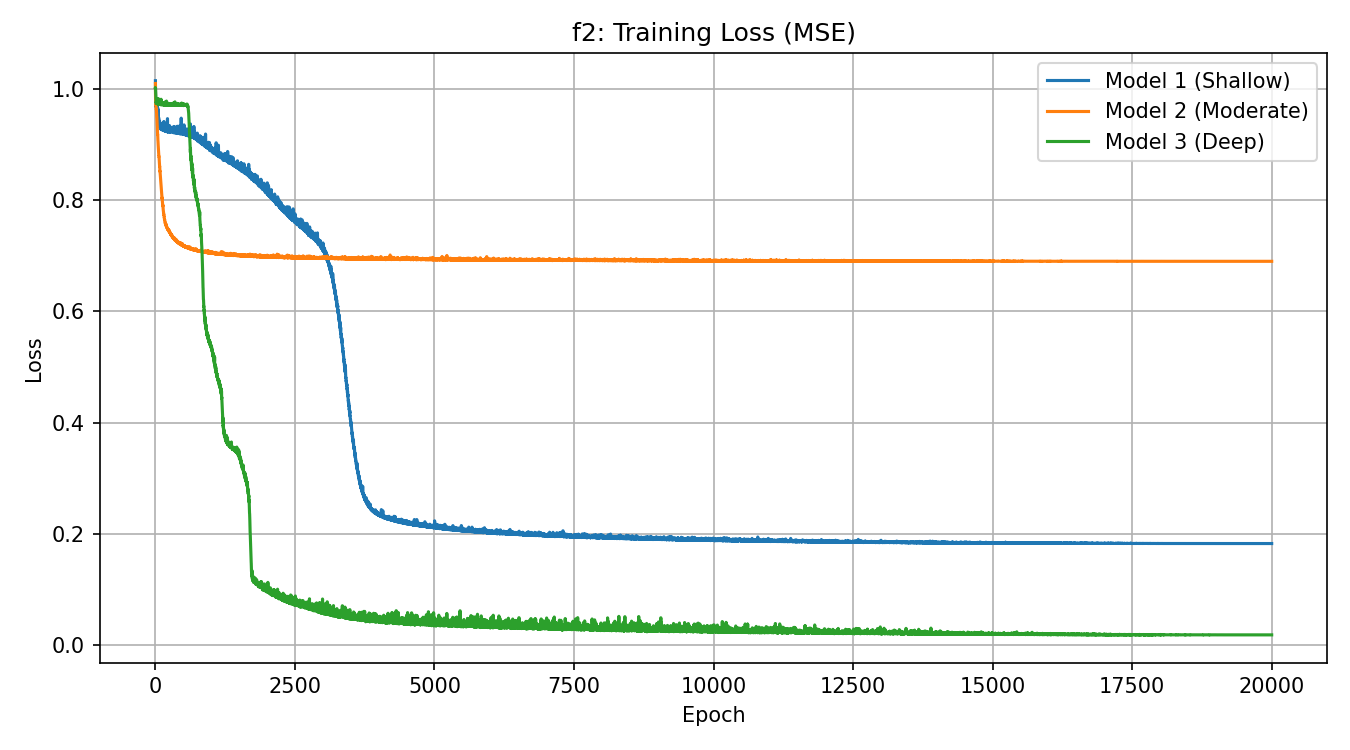

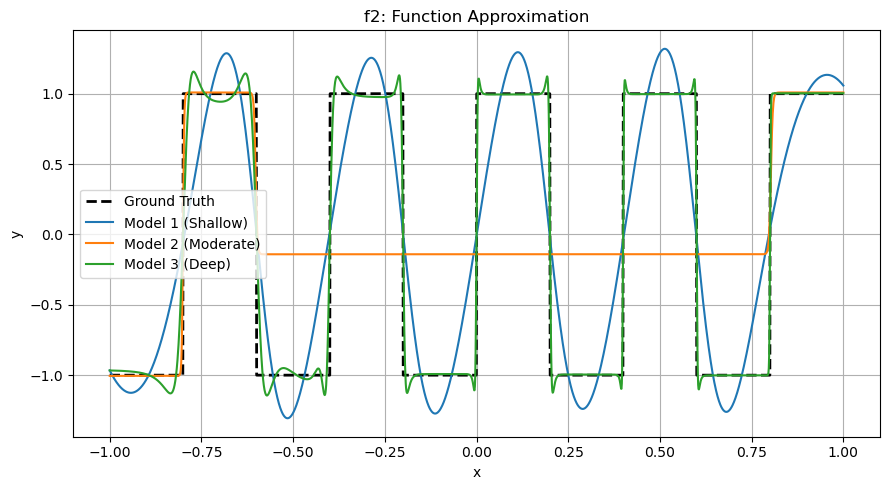

Saved: results/f2_fit.png


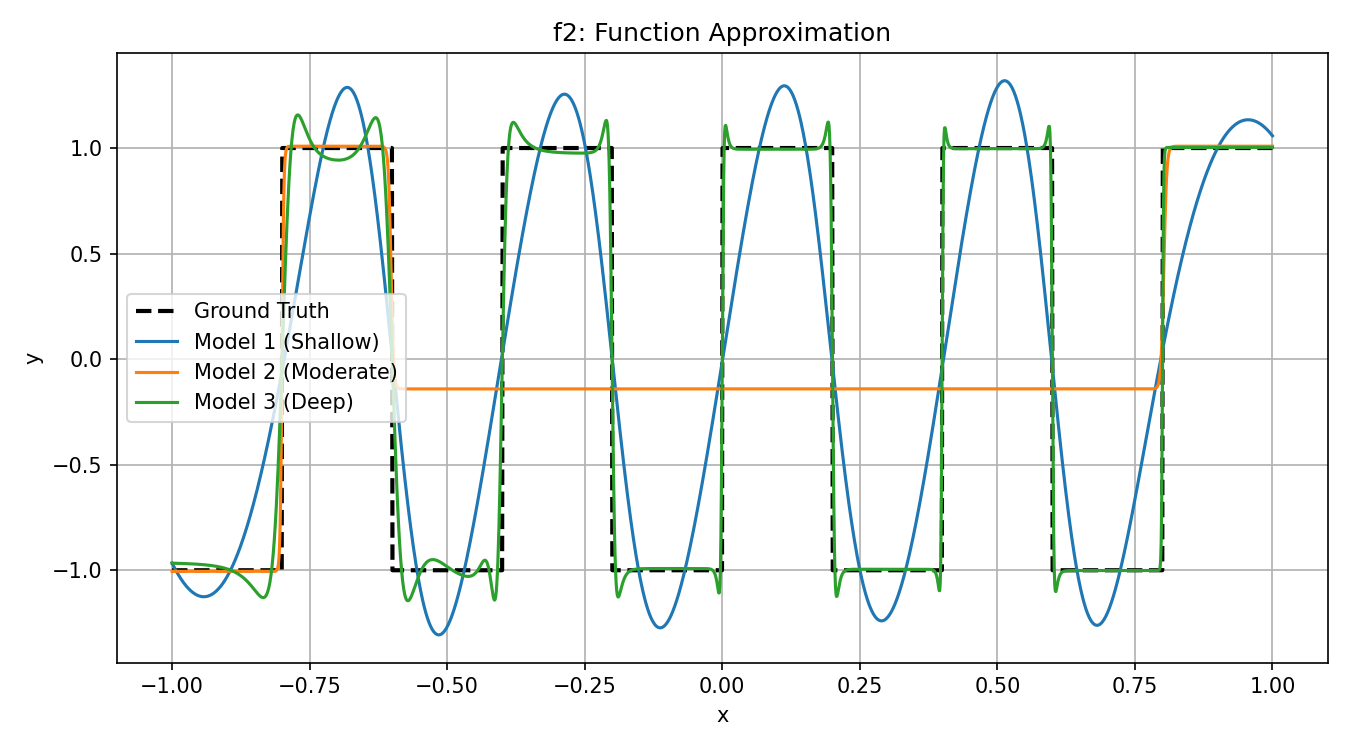

In [3]:
try:
    from IPython.display import display, Image
except ImportError:
    display = None
    Image = None
def set_seed(seed: int = 2025):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(2025)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def func1_np(x: np.ndarray) -> np.ndarray:
    return np.sinc(5.0 * x).astype(np.float32)

def func2_np(x: np.ndarray) -> np.ndarray:
    return np.sign(np.sin(5.0 * np.pi * x)).astype(np.float32)

def plot_two_targets_side_by_side(x_min=-1.0, x_max=1.0, n_points=2048, outdir="results"):
    os.makedirs(outdir, exist_ok=True)
    xs = np.linspace(x_min, x_max, n_points).astype(np.float32)
    y1 = func1_np(xs)
    y2 = func2_np(xs)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)
    axes[0].plot(xs, y1)
    axes[0].set_title("Function 1: sinc(5*pi*x) / (5*pi*x)")
    axes[0].set_xlabel("x"); axes[0].set_ylabel("y"); axes[0].grid(True)

    axes[1].plot(xs, y2, color="red")
    axes[1].set_title("Function 2: sgn(sin(5*pi*x))")
    axes[1].set_xlabel("x"); axes[1].set_ylabel("y"); axes[1].grid(True)

    plt.tight_layout()
    dest = os.path.join(outdir, "targets_f1_f2_side_by_side.png")
    plt.savefig(dest, dpi=150); plt.show(); plt.close()
    print(f"Saved: {dest}")
    if display and Image: display(Image(filename=dest))


def make_dataset(func: Callable[[np.ndarray], np.ndarray],
                 n_points: int = 2048,
                 x_min: float = -1.0,
                 x_max: float = 1.0,
                 noise_std: float = 0.0) -> Tuple[DataLoader, np.ndarray, np.ndarray]:
    xs = np.linspace(x_min, x_max, n_points).astype(np.float32)
    ys = func(xs).astype(np.float32)
    if noise_std > 0:
        ys = ys + np.random.normal(0, noise_std, size=ys.shape).astype(np.float32)
    x_t = torch.tensor(xs).unsqueeze(1)  # (N,1)
    y_t = torch.tensor(ys).unsqueeze(1)  # (N,1)
    train_loader = DataLoader(TensorDataset(x_t, y_t), batch_size=256, shuffle=True)
    return train_loader, xs, ys


def _ensure_activation(act):
    return act() if isinstance(act, type) else act

def count_params(m: nn.Module) -> int:
    return sum(p.numel() for p in m.parameters() if p.requires_grad)


class ShallowMLP(nn.Module):
    def __init__(self, width=200, act=nn.Tanh):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, width),
            _ensure_activation(act),
            nn.Linear(width, 1)
        )
    def forward(self, x): return self.net(x)

class ModerateMLP(nn.Module):
    def __init__(self, h1=149, h2=2, act=nn.Tanh):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, h1), _ensure_activation(act),
            nn.Linear(h1, h2), _ensure_activation(act),
            nn.Linear(h2, 1)
        )
    def forward(self, x): return self.net(x)

class DeepMLP(nn.Module):
    def __init__(self, widths=(1,1,3,21,22), act=nn.Tanh):
        super().__init__()
        layers, in_dim = [], 1
        for w in widths:
            layers += [nn.Linear(in_dim, w), _ensure_activation(act)]
            in_dim = w
        layers += [nn.Linear(in_dim, 1)]
        self.net = nn.Sequential(*layers)
    def forward(self, x): return self.net(x)


@dataclass
class TrainCfg:
    lr: float = 2e-3
    epochs: int = 20000
    cosine_decay: bool = True
    weight_decay: float = 0.0
    log_every: int = 200  # print progress every N epochs

def train_model(model: nn.Module,
                train_loader: DataLoader,
                cfg: TrainCfg,
                model_name: str,
                func_name: str) -> List[float]:
    print(f" Training {model_name} on function {func_name} ...")
    model.to(device)
    opt = Adam(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=cfg.epochs) if cfg.cosine_decay else None
    crit = nn.MSELoss()

    train_losses = []
    for epoch in range(cfg.epochs):
        model.train()
        running = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = crit(pred, yb)
            opt.zero_grad()
            loss.backward()
            opt.step()
            running += loss.item() * xb.size(0)

        train_loss = running / len(train_loader.dataset)
        train_losses.append(train_loss)

        if (epoch + 1) % cfg.log_every == 0:
            lr_now = opt.param_groups[0]["lr"]
            print(f"   epoch {epoch+1:5d}/{cfg.epochs} | loss {train_loss:.8f} | lr {lr_now:.2e}")

        if scheduler:
            scheduler.step()

    print(f" Done: {model_name} on {func_name}")
    return train_losses


def run_one(func_name: str = "f1", act=nn.Tanh, outdir="results"):
    os.makedirs(outdir, exist_ok=True)
    fn = func1_np if func_name == "f1" else func2_np
    print(f"\n=== Training on {func_name} ===")

    
    if func_name == "f1":
        plot_two_targets_side_by_side(outdir=outdir)

    train_loader, xs, ys = make_dataset(fn, n_points=2048)

    
    m1 = ShallowMLP(width=200, act=act)                 
    m2 = ModerateMLP(h1=149, h2=2, act=act)             
    m3 = DeepMLP(widths=(1,1,3,21,22), act=act)         

    
    p1, p2, p3 = count_params(m1), count_params(m2), count_params(m3)
    print(f"Params -> Model 1 (Shallow): {p1}, Model 2 (Moderate): {p2}, Model 3 (Deep): {p3}")
    assert p1 == p2 == p3 == 601, "Parameter counts must all be 601."

    cfg = TrainCfg()

    
    t1 = train_model(m1, train_loader, cfg, "Model 1 (Shallow)", func_name)
    t2 = train_model(m2, train_loader, cfg, "Model 2 (Moderate)", func_name)
    t3 = train_model(m3, train_loader, cfg, "Model 3 (Deep)", func_name)

    
    with torch.no_grad():
        xt = torch.tensor(xs, dtype=torch.float32).unsqueeze(1).to(device)
        y1 = m1(xt).cpu().squeeze().numpy()
        y2 = m2(xt).cpu().squeeze().numpy()
        y3 = m3(xt).cpu().squeeze().numpy()

    
    plt.figure(figsize=(9,5))
    plt.plot(t1, label="Model 1 (Shallow)")
    plt.plot(t2, label="Model 2 (Moderate)")
    plt.plot(t3, label="Model 3 (Deep)")
    plt.title(f"{func_name}: Training Loss (MSE)")
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.legend(); plt.grid(True); plt.tight_layout()
    f_loss = os.path.join(outdir, f"{func_name}_loss.png")
    plt.savefig(f_loss, dpi=150); plt.show(); plt.close()
    print(f"Saved: {f_loss}")
    if display and Image: display(Image(filename=f_loss))

    
    plt.figure(figsize=(9,5))
    plt.plot(xs, ys, 'k--', linewidth=2, label="Ground Truth")
    plt.plot(xs, y1, label="Model 1 (Shallow)")
    plt.plot(xs, y2, label="Model 2 (Moderate)")
    plt.plot(xs, y3, label="Model 3 (Deep)")
    plt.title(f"{func_name}: Function Approximation")
    plt.xlabel("x"); plt.ylabel("y")
    plt.legend(); plt.grid(True); plt.tight_layout()
    f_fit = os.path.join(outdir, f"{func_name}_fit.png")
    plt.savefig(f_fit, dpi=150); plt.show(); plt.close()
    print(f"Saved: {f_fit}")
    if display and Image: display(Image(filename=f_fit))

if __name__ == "__main__":
    
    run_one("f1", act=nn.Tanh)
    
    run_one("f2", act=nn.Tanh)
